<a href="https://colab.research.google.com/github/swapnilbetkar/python/blob/Dev_Self/VehicleCollision3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [7]:
# Importing necesssary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [8]:
#import dataset
dataset = pd.read_csv("/content/drive/MyDrive/Datasets/VehicleCollisions.csv")
pd.set_option('display.max_columns',None)
dataset.head()
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37869 entries, 0 to 37868
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Number_of_Vehicles       37869 non-null  int64 
 1   Road_Type                37869 non-null  object
 2   Speed_limit              37869 non-null  int64 
 3   Light_Conditions         37869 non-null  object
 4   Weather_Conditions       37869 non-null  object
 5   Road_Surface_Conditions  37869 non-null  object
 6   Urban_or_Rural_Area      37869 non-null  object
 7   Vehicle_Manoeuvre        37869 non-null  object
 8   1st_Point_of_Impact      37869 non-null  object
 9   Sex_of_Driver            37869 non-null  object
 10  Age_of_Driver            37869 non-null  int64 
 11  Engine_Capacity_(CC)     37869 non-null  int64 
 12  Damage                   37869 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.8+ MB
None


In [9]:
#### Data Preparation

dataset['Damage'] = dataset['Damage'].map({'Light':0, 'Severe':1})
labelEncoder = LabelEncoder()
categorical_features = ['Urban_or_Rural_Area','Sex_of_Driver']
dataset[categorical_features] = dataset[categorical_features].apply(labelEncoder.fit_transform)

## Creating a correlation heat map to identify relationship between features.
corrs = dataset.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure.show()

## Applying one hot encoding to nominal categorical features
categorical_feature = ['1st_Point_of_Impact','Road_Type','Light_Conditions','Weather_Conditions','Road_Surface_Conditions','Vehicle_Manoeuvre']
final_data = pd.get_dummies(dataset, columns = categorical_feature)


## Dividing dataset into label and feature sets
X = final_data.drop(['Damage','Urban_or_Rural_Area'], axis = 1) #Found a strong correlation and causality between the features 'Urban_or_Rural_Area' and 'Speed_limit' hence dropping 'Urban_or_Rural_Area'
Y = final_data['Damage']
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)



<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(37869, 40)
(37869,)


In [10]:
##### Balancing the dataset hyperparamters tuning

print("Number of observations in each class before oversampling \n", pd.Series(Y).value_counts())

model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1) )
    ])
grid_param = {'classification__n_estimators': [10,20,30,40,50,100]}

gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='precision', cv=5)

gd_sr.fit(X_scaled, Y)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

Number of observations in each class before oversampling 
 0    35312
1     2557
Name: Damage, dtype: int64
{'classification__n_estimators': 30}
0.0986316658278136


In [11]:
## Fitting the dataset to model with identified hyparameter values
rfc = RandomForestClassifier(n_estimators=30, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_scaled,Y)

##Creating a feature importance list to identify significant features
featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Engine_Capacity_(CC)                           0.385805
Age_of_Driver                                  0.319377
Speed_limit                                    0.044928
Number_of_Vehicles                             0.036392
Sex_of_Driver                                  0.023442
1st_Point_of_Impact_Front                      0.013066
Vehicle_Manoeuvre_Turning                      0.012530
1st_Point_of_Impact_Nearside                   0.011231
Vehicle_Manoeuvre_Going ahead                  0.010747
Road_Type_Single carriageway                   0.010362
1st_Point_of_Impact_Offside                    0.009916
Road_Type_Dual carriageway                     0.009325
Road_Surface_Conditions_Wet or damp            0.009183
1st_Point_of_Impact_Back                       0.009119
Road_Surface_Conditions_Dry                    0.009114
Weather_Conditions_Fine no high winds          0.007700
Light_Conditions_Darkness lights lit           0.007306
Light_Conditions_Daylight                      0

In [12]:
#### Re-training model by using significant features
X = final_data[['Engine_Capacity_(CC)','Age_of_Driver','Speed_limit']]

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

model = Pipeline([
        ('balancing', SMOTE(random_state = 101)),
        ('classification', RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1) )
    ])
grid_param = {'classification__n_estimators': [10,20,30,40,50,100]}

gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring='precision', cv=5)

gd_sr.fit(X_scaled, Y)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'classification__n_estimators': 50}
0.07194471345377453


AxesSubplot(0.125,0.125;0.775x0.755)


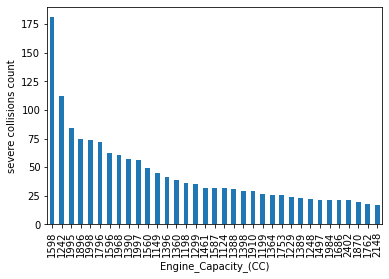

In [112]:
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_scaled,Y)

####  Data visualisation to assess the significant features 

pd.set_option('display.max_rows', final_data.shape[0]+1)
df_Severe = final_data[final_data['Damage'] == 1]
df_Light = final_data[final_data['Damage'] == 0]
df.head()
df_EngineCapacity_Severe = df_Severe.groupby('Engine_Capacity_(CC)')['Damage'].count().sort_values(ascending = False).head(35)
df_AgeOfDriver_Severe = df_Severe.groupby('Age_of_Driver')['Damage'].count().sort_values(ascending = False).head(35)

df_EngineCapacity_Light = df_Light.groupby('Engine_Capacity_(CC)')['Damage'].count().sort_values(ascending = False).head(35)
df_AgeOfDriver_light = df_Light.groupby('Age_of_Driver')['Damage'].count().sort_values(ascending = False).head(35)

print(df_EngineCapacity_Severe.plot(ylabel='severe collisions count',kind="bar"))

AxesSubplot(0.125,0.125;0.775x0.755)


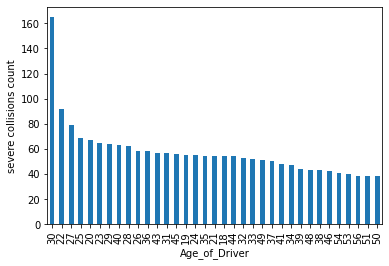

In [113]:
print(df_AgeOfDriver_Severe.plot(ylabel='severe collisions count',kind="bar"))

AxesSubplot(0.125,0.125;0.775x0.755)


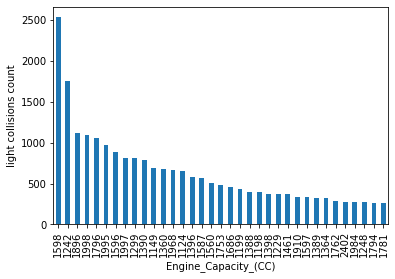

In [114]:
print(df_EngineCapacity_Light.plot(ylabel='light collisions count',kind="bar"))

AxesSubplot(0.125,0.125;0.775x0.755)


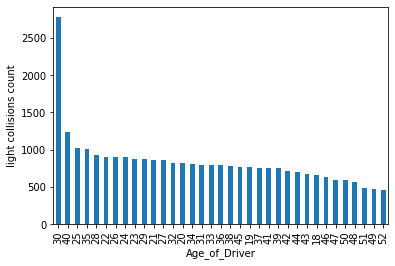

In [115]:
print(df_AgeOfDriver_light.plot(ylabel='light collisions count',kind="bar"))